In [31]:
# install required libraries
!pip install sdv # install the synthetic data vault library
!pip install xlrd

In [32]:
# import data science libraries
import pandas as pd
import numpy as np
import math

# import scikit-learn preprocessing
from sklearn.preprocessing import LabelEncoder, QuantileTransformer

# import pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# import synthetic data vault libraries
from sdv.metadata import SingleTableMetadata
import sdv.evaluation.single_table as sdv_st

# import utility libraries
from tqdm import tqdm
import xlrd
import requests
from io import BytesIO
from zipfile import ZipFile
from datetime import datetime

# import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# set random seed
seed = 1234

# set dimension of categorical embeddings
cat_emb_dim = 2

# set number of neurons per layer
mlp_layers = [1024, 1024, 1024, 1024]

# set non-linear activation function
activation = 'lrelu'

# set number of diffusion steps
diffusion_steps = 500

# set diffusion start and end betas
diffusion_beta_start = 1e-4
diffusion_beta_end = 0.02

# set diffusion scheduler
scheduler = 'linear'

# set number of training epochs
epochs = 500

# set training batch size
batch_size = 512

# set training learning rate
learning_rate = 1e-4

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu").type

In [35]:
# set numpy seed
np.random.seed(seed)

# set pytorch seed
torch.manual_seed(seed)

# set cuda seed
torch.cuda.manual_seed(seed)
# read the UCI credit card dataset
train_raw =pd.read_csv('/kaggle/input/processed-data/processedData.csv')

In [36]:
label = train_raw['Label']
# init the quantile transformation
scaler = QuantileTransformer(output_distribution='normal', random_state=seed)
scaler.fit(train_raw.drop(columns=['Label']))
train_scaled = scaler.transform(train_raw.drop(columns=['Label']))
train_scaled

array([[ 1.12362401, -0.20465992, -0.25749484, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-0.41054988,  0.50919609, -0.25749484, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-1.09814061,  0.66585231, -0.25749484, ..., -5.19933758,
        -5.19933758, -5.19933758],
       ...,
       [-1.20313318, -0.20465992, -0.25749484, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [ 1.94619602,  0.38167465, -0.25749484, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [ 1.57865508,  0.38167465, -0.25749484, ..., -5.19933758,
        -5.19933758, -5.19933758]])

In [37]:
train = torch.FloatTensor(train_scaled)
# convert label
label_torch = torch.LongTensor(label)

train_set = TensorDataset(train, label_torch)

# init the data loader
dataloader = DataLoader(
    dataset=train_set, # training dataset
    batch_size=batch_size, # training batch size
    num_workers=0, # number of workers
    shuffle=True # shuffle training data
)

In [38]:
# define base feedforward network
class BaseNetwork(nn.Module):

    # define base network constructor
    def __init__(self, hidden_size, activation='lrelu'):

        # call super calass constructor 
        super(BaseNetwork, self).__init__()

        # init 
        self.layers = self.init_layers(hidden_size)

        # case: lrelu activation
        if activation == 'lrelu':

            # set lrelu activation
            self.activation = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # case: relu activation
        elif activation == 'relu':

            # set relu activation
            self.activation = nn.ReLU(inplace=True)

        # case: tanh activation
        elif activation == 'tanh':

            # set tanh activation
            self.activation = nn.Tanh()

        # case: sigmoid activation
        else:

            # set sigmoid activation
            self.activation = nn.Sigmoid()

    # define layer initialization 
    def init_layers(self, layer_dimensions):

        # init layers
        layers = []

        # iterate over layer dimensions 
        for i in range(len(layer_dimensions)-1):

            # init linear layer 
            layer = nn.Linear(layer_dimensions[i], layer_dimensions[i + 1], bias=True)
            
            # init linear layer weights
            nn.init.xavier_uniform_(layer.weight)
            
            # init linear layer bias
            nn.init.constant_(layer.bias, 0.0)

            # collecet linear layer 
            layers.append(layer)
            
            # register linear layer parameters
            self.add_module('linear_' + str(i), layer)

        # return layers
        return layers

    # define forward pass
    def forward(self, x):

        # iterate over layers
        for i in range(len(self.layers)):

            # run layer forward pass 
            x = self.activation(self.layers[i](x))

        # return forward pass result
        return x

In [39]:
class MLPSynthesizer(nn.Module):
    def __init__(
            self, 
            d_in: int, 
            hidden_layers: list, 
            activation: str='lrelu',  # Layer activation
            dim_t: int=64             # Time embedding dimension
        ):
        super(MLPSynthesizer, self).__init__()
        
        self.dim_t = dim_t

        # Define backbone feedforward network
        self.backbone = BaseNetwork([dim_t, *hidden_layers], activation=activation)

        # Input data projection
        self.projection = nn.Sequential(
            nn.Linear(d_in, dim_t),  # Linear layer
            nn.SiLU(),              # SiLU activation
            nn.Linear(dim_t, dim_t) # Linear layer
        )
        
        # Time embedding projection
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t),  # Linear layer
            nn.SiLU(),               # SiLU activation
            nn.Linear(dim_t, dim_t)  # Linear layer
        )
        
        # Output data projection
        self.head = nn.Linear(hidden_layers[-1], d_in)

    # Sinusoidal time embedding
    def embed_time(self, timesteps, dim_out, max_period=10000):
        half_dim_out = dim_out // 2
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half_dim_out, dtype=torch.float32) / half_dim_out)
        freqs = freqs.to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        time_embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

        if dim_out % 2:  # Odd dimension case
            time_embedding = torch.cat([time_embedding, torch.zeros_like(time_embedding[:, :1])], dim=-1)
        return time_embedding

    # Forward pass
    def forward(self, x, timesteps):
        # Time embeddings
        time_emb = self.embed_time(timesteps, self.dim_t)
        time_emb = self.time_embed(time_emb)

        # Input projection
        x = self.projection(x)

        # Add time embeddings
        x = x + time_emb

        # Backbone forward pass
        x = self.backbone(x)

        # Output projection
        x = self.head(x)
        return x


In [40]:
# define BaseDiffuser network
class BaseDiffuser(object):

    # define base diffuser network constructor
    def __init__(
            self, 
            total_steps=1000, 
            beta_start=1e-4, 
            beta_end=0.02, 
            device='cpu',
            scheduler='linear'
        ):

        # set diffusion steps
        self.total_steps = total_steps

        # set diffusion start beta
        self.beta_start = beta_start

        # set diffusion end beta
        self.beta_end = beta_end

        # set compute device
        self.device = device

        # set noise schedule alphas and betas
        self.alphas, self.betas = self.prepare_noise_schedule(scheduler=scheduler)

        # set noise schedule alhpa hats
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

    # define noise schedule
    def prepare_noise_schedule(self, scheduler: str):

        # determine noise scheduler scale
        scale = 1000 / self.total_steps

        # scale beta start
        beta_start = scale * self.beta_start

        # scale beta end
        beta_end = scale * self.beta_end

        # case: linear noise scheduler
        if scheduler == 'linear':

            # determine linear noise schedule betas
            betas = torch.linspace(beta_start, beta_end, self.total_steps)

            # determine linear noise schedule alphas
            alphas = 1.0 - betas

        # case: quadratic noise scheduler
        elif scheduler == 'quad':

            # determine quadratic noise schedule betas
            betas = torch.linspace(self.beta_start ** 0.5, self.beta_end ** 0.5, self.total_steps) ** 2

            # determine quadratic noise schedule alphas 
            alphas = 1.0 - betas

        # return noise scheduler alphas and betas
        return alphas.to(self.device), betas.to(self.device)

    # define random timesteps sampler 
    def sample_random_timesteps(self, n: int):

        # sample random timesteps
        t = torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

        # return random timesteps
        return t

    # define gaussian noise addition
    def add_gauss_noise(self, x_num, t):

        # determine noise alpha hat
        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None]

        # determine noise one minius alpha hat 
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None]

        # determine numeric noise
        noise_num = torch.randn_like(x_num)

        # determine x numeric noise
        x_noise_num = sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num

        # return x numeric noise and numeric noise
        return x_noise_num, noise_num

    # define gaussian noise sampling
    def p_sample_gauss(self, model_out, z_norm, timesteps):

        # determine noise alpha hat
        sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None]

        # determine noise betas
        betas_t = self.betas[timesteps][:, None]
        
        # determine noise one minius alpha hat 
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None]
        
        epsilon_t = torch.sqrt(self.betas[timesteps][:, None])

        # determine random noise
        random_noise = torch.randn_like(z_norm)
        random_noise[timesteps == 0] = 0.0

        # determine model mean
        model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))

        # determine z norm
        z_norm = model_mean + (epsilon_t * random_noise)

        # return z norm
        #represente les donnes reconstruit ou débruitées
        return z_norm

In [41]:
# initialize the FinDiff synthesizer model 
synthesizer_model = MLPSynthesizer(
    d_in=30,
    hidden_layers=mlp_layers,
    activation=activation,
)

In [43]:
# initialize the FinDiff base diffuser model
diffuser_model = BaseDiffuser(
    total_steps=diffusion_steps,
    beta_start=diffusion_beta_start,
    beta_end=diffusion_beta_end,
    scheduler=scheduler,
    device=device
)

In [44]:
# determine synthesizer model parameters
parameters = filter(lambda p: p.requires_grad, synthesizer_model.parameters())

# init Adam optimizer
optimizer = optim.Adam(parameters, lr=learning_rate)

# init learning rate scheduler
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=False)

# int mean-squared-error loss
loss_fnc = nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [45]:
# Init collection of training epoch losses
train_epoch_losses = []

# Set the model in training mode
synthesizer_model.train()

# Move to the device
synthesizer_model = synthesizer_model.to(device)

# Init the training progress bar 
pbar = tqdm(iterable=range(epochs), position=0, leave=True)

# Iterate over training epochs
for epoch in pbar:

    base_params = {'epoch': epoch, 'seed': seed, 'mlp_layers': mlp_layers}

    # Init epoch training batch losses
    batch_losses = []

    # Iterate over epoch batches
    for batch_x, batch_y in dataloader:

        # Move tensors to device
        batch_x = batch_x.to(device)  # Only numerical data, no batch_cat
        batch_y = batch_y.to(device)

        # Sample diffusion timestep
        timesteps = diffuser_model.sample_random_timesteps(n=batch_x.shape[0])

        # Conduct synthesizer model forward pass with only numerical data
        predicted_noise = synthesizer_model(x=batch_x, timesteps=timesteps)

        # Compute training batch loss
        batch_loss = loss_fnc(input=batch_x, target=predicted_noise)

        # Reset model gradients
        optimizer.zero_grad()

        # Run model backward pass
        batch_loss.backward()

        # Optimize model parameters
        optimizer.step()

        # Collect training batch losses
        batch_losses.append(batch_loss.detach().cpu().numpy())

    # Determine mean training epoch loss
    batch_losses_mean = np.mean(np.array(batch_losses))

    # Update learning rate scheduler
    lr_scheduler.step()

    # Collect mean training epoch loss
    train_epoch_losses.append(batch_losses_mean)

    # Prepare and set training epoch progress bar update
    now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    pbar.set_description('[LOG {}] epoch: {}, train-loss: {}'.format(str(now), str(epoch).zfill(4), str(batch_losses_mean)))


[LOG 2025-01-13 08:39:26] epoch: 0499, train-loss: 1.677132e-05: 100%|██████████| 500/500 [20:49<00:00,  2.50s/it]  


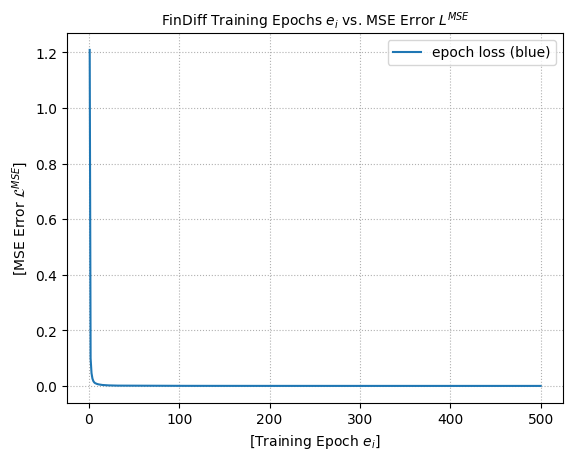

In [46]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel('[Training Epoch $e_i$]', fontsize=10)
ax.set_ylabel('[MSE Error $\mathcal{L}^{MSE}$]', fontsize=10)

# set plot legend
plt.legend(loc='upper right', numpoints=1, fancybox=True)

# add plot title
plt.title('FinDiff Training Epochs $e_i$ vs. MSE Error $L^{MSE}$', fontsize=10);

In [49]:
# init samples to be generated
samples = torch.randn((len(label_torch), 30), device=device)
labels_list = label_torch.cpu().numpy()

# init the generation progress bar
pbar = tqdm(iterable=reversed(range(0, diffusion_steps)), position=0, leave=True)

with torch.no_grad():
  # iterate over diffusion steps
  for diffusion_step in pbar:

      # prepare and set training epoch progress bar update
      now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
      pbar.set_description('[LOG {}] Diffusion Step: {}'.format(str(now), str(diffusion_step).zfill(4)))

      # init diffusion timesteps
      timesteps = torch.full((len(label_torch),), diffusion_step, dtype=torch.long, device=device)

      # run synthesizer model forward pass
      model_out = synthesizer_model(x=samples.float(), timesteps=timesteps)

      # run diffuser model forward pass
      samples = diffuser_model.p_sample_gauss(model_out, samples, timesteps)

[LOG 2025-01-13 08:45:22] Diffusion Step: 0000: : 500it [02:49,  2.94it/s]


In [52]:
# Split sample into numeric part (since no categorical data, we'll use all the scaled data)
if isinstance(samples, torch.Tensor):
    samples = samples.detach().cpu().numpy()
else:
    # If samples is already a NumPy array, skip detach and directly use it
    samples = samples

# The entire sample is numeric, as you are working with scaled data
samples_num = samples

# Denormalize using the same QuantileTransformer fitted on the training data
z_norm_upscaled = scaler.inverse_transform(samples_num)
z_norm_df = pd.DataFrame(z_norm_upscaled, columns=train_raw.drop(columns=['Label']).columns)

# Add label to the dataframe (labels are already in 0 or 1 format)
samples_decoded = z_norm_df.copy()
samples_decoded['Label'] = labels_list  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [53]:
samples_decoded

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,...,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
0,0.000000,53.0,251.0,164.0,1.000000e+00,11098.0,13339242.0,0.0,0.0,0.0,...,0.0,0.0,65160.0,65160.0,65280.0,65442.0,0.0,0.000000e+00,331.0,0
1,65535.000000,0.0,251.0,164.0,1.000000e+00,1.0,13339242.0,0.0,0.0,0.0,...,1752.0,560.0,0.0,65160.0,65280.0,65442.0,0.0,3.352447e+09,331.0,0
2,65535.000000,65502.0,251.0,164.0,1.018586e+07,11098.0,0.0,27.0,0.0,453.0,...,0.0,0.0,65160.0,0.0,65280.0,0.0,0.0,0.000000e+00,331.0,0
3,65535.000000,0.0,251.0,164.0,9.649825e+06,11098.0,0.0,27.0,4294952.0,453.0,...,0.0,0.0,65160.0,0.0,65280.0,65442.0,0.0,0.000000e+00,331.0,0
4,65535.000000,0.0,251.0,164.0,1.000000e+00,1.0,13332059.0,0.0,0.0,0.0,...,1752.0,560.0,0.0,65160.0,65280.0,65442.0,0.0,3.352447e+09,331.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165662,65535.000000,0.0,1.0,164.0,1.000000e+00,11098.0,13339242.0,0.0,0.0,0.0,...,1752.0,560.0,0.0,65160.0,65280.0,65442.0,0.0,3.352447e+09,331.0,1
165663,65535.000000,65502.0,251.0,164.0,1.018586e+07,11098.0,0.0,27.0,0.0,453.0,...,0.0,0.0,65160.0,65160.0,65280.0,0.0,0.0,0.000000e+00,331.0,1
165664,65534.773438,0.0,1.0,0.0,1.000000e+00,11098.0,0.0,0.0,0.0,0.0,...,1752.0,560.0,0.0,65160.0,65280.0,65442.0,0.0,3.352447e+09,331.0,1
165665,65535.000000,0.0,251.0,0.0,1.018586e+07,11098.0,13339242.0,0.0,0.0,453.0,...,1752.0,560.0,0.0,65160.0,65280.0,0.0,36477.0,0.000000e+00,331.0,1


In [55]:
samples_decoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165667 entries, 0 to 165666
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   L4_SRC_PORT                 165667 non-null  float32
 1   L4_DST_PORT                 165667 non-null  float32
 2   PROTOCOL                    165667 non-null  float32
 3   L7_PROTO                    165667 non-null  float32
 4   IN_BYTES                    165667 non-null  float32
 5   IN_PKTS                     165667 non-null  float32
 6   OUT_BYTES                   165667 non-null  float32
 7   TCP_FLAGS                   165667 non-null  float32
 8   FLOW_DURATION_MILLISECONDS  165667 non-null  float32
 9   DURATION_IN                 165667 non-null  float32
 10  DURATION_OUT                165667 non-null  float32
 11  MIN_TTL                     165667 non-null  float32
 12  LONGEST_FLOW_PKT            165667 non-null  float32
 13  SHORTEST_FLOW_

In [56]:
# Specify the file path and file name
output_file = '/kaggle/working/generated_dataset.csv'

# Save the DataFrame to a CSV file
samples_decoded.to_csv(output_file, index=False)

print(f"Dataset saved to {output_file}")

Dataset saved to /kaggle/working/generated_dataset.csv
